<a href="https://colab.research.google.com/github/lanyu0322/PUS2020_LYu/blob/master/HW8/HW8_RandomForest_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Following the paper "Examining the feasibility of using open data to benchmark building energy usage in cities: A data science and policy perspective" [Roth et al 2019](https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective), choose 2 cities in the dataset available through the paper's github repository https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking

This paper is an excellent example of reproducible research. 

I also created an example of using random forest classifier and regressors here https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemos/COVID19LOS_featureExtractionRFexample.ipynb and there are links at the bottom of this notebook to useful functions and examples on the internet of applications of methods you will need to use.

1. Read the introduction to the paper and describe here (briefly) the goals of their analysis (and the analysis that you are about to reproduce). Max 200 words.
2. Choose 2 cities (any 2 cities except Seattle cause I am running some of the Seattle analysis below for guidance)
3. For each of the 2 cities reproduce their analysis by 

  3.1 gathering the original data from their repository (see below for Seattle example)

  3.2 clean the data according to their data preparation scheme, including one-hot-encoding categorical variables, except to impute missing data using KNearestNeighors instead of Gibbs sampling (see below)

  3.3 run a Random Forest (RF) Regressor to predict the total energy consumption.

  3.4 evaluate the RF model performance by printing the R2 score (the default score in SKLearn RF) for training and test set (discuss)

  3.5 plot the features sorted by their importance and identify the most important features. are they consistent between the 2 cities? are they consistent with the paper's result?
4 compare the result for the 2 cities (discuss)

5. Extra credit: 

  5.1 modify the target variable to a binary variable choosing the median of the variable values as the the energy threshold and predict whether the value is higher or lower than the threshold
  5.2 Run a Random Forest Classifier to predict if an observation is in the upper 50% percentile or lower 50% percentile (above or below the median threshold)
  5.3 Measure the performance of the model on training and test data
  5.4 Measure the feature importance and assess if the important feature have changed (discuss)

# Introduction

 In this research, the author is measuring building energy performance since buildings are the largest source of urban energy consumption. The goal of this research is evaluating the feasibility of using public open data in two benchmarking models(lasso regression and random forest) and compare results to the same models but using Commercial Building Energy Consumption Survey dataset. In my analysis, I will use the same data and run a Random Forest (RF) Regressor to predict the total energy consumption. Then, I would like to plot the features sorted by their importance and identify the most important features.

In [150]:
import pandas as pd
import numpy as np

# choose a city and read in the data

In [151]:
dc = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/master/DC/DC_final.csv")
dc = dc.drop("Unnamed: 0", axis=1)

In [152]:
dc


,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
0,In Compliance,4,20011,1959,Multifamily Housing,Multifamily Housing,63227.0,65000.0,6963.5,Whole Building,Whole Building,633043.8,44274.183070,9.0,101.3,102.7,175.9,174.9,482.9,7.4,6584500.0,15.700229
1,In Compliance,2,20005,1997,Office,Office,251557.0,257943.0,8490.0,Whole Building,Whole Building,5531486.0,NaN,69.0,73.2,73.2,229.8,229.8,2164.4,8.4,18881427.6,16.753689
2,In Compliance,2,20036,1964,Office,Office,330550.0,223218.0,8749.1,Whole Building,Whole Building,3863003.0,64143.386660,76.0,87.8,89.0,215.6,215.0,1852.2,8.3,19598540.4,16.790966
3,In Compliance,2,22202,1969,Office,Office,256839.0,213067.0,5393.8,Whole Building,Whole Building,2936445.0,NaN,87.0,47.0,46.4,147.7,145.8,1249.2,5.9,10014149.0,16.119510
4,In Compliance,2,20037,1975,Office,Office,370000.0,381518.0,10422.6,Whole Building,Whole Building,7345290.0,NaN,85.0,65.7,65.7,206.3,206.3,2874.1,7.5,25065732.6,17.037012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,In Compliance,5,20017,2013,Multifamily Housing,Multifamily Housing,186504.0,99365.0,3632.8,Whole Building,Whole Building,1074708.0,7011.827737,89.0,44.0,44.3,123.3,123.6,457.8,4.6,4372060.0,15.290745
1451,In Compliance,5,20017,2013,Multifamily Housing,Multifamily Housing,162898.0,162898.0,5737.4,Whole Building,Whole Building,1740264.0,5418.386531,46.0,39.8,39.8,117.9,117.9,709.7,4.4,6483340.4,15.684746
1452,In Compliance,5,20017,2014,Multifamily Housing,Multifamily Housing,196755.0,196755.0,11079.4,Whole Building,Whole Building,2948059.0,27518.532620,5.0,65.1,65.5,175.2,175.7,1299.7,6.6,12808750.5,16.365639
1453,Data under review by DOEE,1,20059,1979,College/University,Other,1095275.0,145000.0,14218.5,Whole Building,Whole Building,NaN,19007.333460,NaN,13.1,13.1,13.8,13.8,101.0,0.7,1899500.0,14.457101


In [153]:
ld = pd.read_csv("https://raw.githubusercontent.com/Urban-Informatics-Lab/Open-Data-Benchmarking/master/London/london_final.csv")
ld  = ld.drop("Unnamed: 0", axis=1)
ld

,rrn,post_town,county,zip,energy_rating_band,energy_rating,total_CO2_emissions_MT,heating_fuel_type,hvac_type,floor_area_M2,fuel_eui_KWHM2,electricity_eui_KWHM2,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,renewables_percent_thermal,renewables_percent_electrical,total_heat_energy_KWH,total_electricity_KWH,total_heat_energy_typical_KWH,total_electricity_typical_KWH,floor_area_SF,total_site_energy_KBTU,log_total_site_energy_KBTU,site_eui_KBTUSF
0,0793-0110-4549-4309-1096,LONDON,Greater London Authority,9729,D,89,99,Natural Gas,Heating and Mechanical Ventilation,1241.00,113,106,237,80,0.0,0.0,140233.00,131546.00,294117.00,99280.00,13357.99990,9.273480e+05,13.740084,69.422668
1,9090-1984-0130-1780-7004,GREENFORD,Greater London Authority,16964,E,102,191,Natural Gas,Heating and Natural Ventilation,2512.00,178,75,225,56,0.0,0.0,447136.00,188400.00,565200.00,140672.00,27038.91680,2.168538e+06,14.589564,80.200617
2,9770-1059-0907-0690-7901,CROYDON,Greater London Authority,3321,D,77,99,Natural Gas,Heating and Natural Ventilation,1555.00,195,47,251,62,0.0,0.0,303225.00,73085.00,390305.00,96410.00,16737.86450,1.284022e+06,14.065508,76.713634
3,0770-0210-5879-1709-4096,CROYDON,Greater London Authority,3320,F,143,95,Natural Gas,Heating and Natural Ventilation,1302.80,225,53,148,40,0.0,0.0,293130.00,69048.40,192814.40,52112.00,14023.20892,1.235803e+06,14.027232,88.125579
4,0166-1060-0216-0290-5501,CROYDON,Greater London Authority,3381,E,106,67,Natural Gas,Air Conditioning,1097.00,103,75,42,91,0.0,0.0,112991.00,82275.00,46074.00,99827.00,11807.99830,6.662749e+05,13.409458,56.425730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23469,0240-4985-0180-7730-0024,WORTHING,NaN,1697,E,120,156,Natural Gas,Heating and Natural Ventilation,1355.00,393,71,310,66,0.0,0.0,532515.00,96205.00,420050.00,89430.00,14585.08450,2.145281e+06,14.578781,147.087297
23470,0950-0310-9579-1907-4006,VIRGINIA WATER,NaN,6225,D,82,114,Natural Gas,Heating and Natural Ventilation,1750.67,117,77,121,103,0.0,0.0,204828.39,134801.59,211831.07,180319.01,18844.03681,1.158865e+06,13.962952,61.497706
23471,0941-0310-0599-6477-0002,SOUTHPORT,NaN,12671,D,99,142,Natural Gas,Heating and Natural Ventilation,1020.00,392,116,462,90,0.0,0.0,399840.00,118320.00,471240.00,91800.00,10979.17800,1.768034e+06,14.385379,161.035231
23472,0271-0110-3899-1327-8006,COVENTRY,NaN,3611,F,149,695,Natural Gas,Heating and Natural Ventilation,5088.00,275,151,167,108,0.0,26.2,1399200.00,768288.00,849696.00,549504.00,54766.72320,7.395773e+06,15.816419,135.041355


# inspect the dataframe

In [154]:
dc.describe()

,ward,year_built,tax_record_floor_area,reported_gross_floor_area,water_use,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
count,1455.000000,1455.000000,1.455000e+03,1.455000e+03,1.455000e+03,1.441000e+03,1.054000e+03,1184.000000,1455.000000,1393.000000,1455.000000,1393.000000,1454.000000,1454.000000,1.455000e+03,1455.000000
mean,3.472852,1940.804811,2.046748e+05,1.897612e+05,5.109905e+04,2.760114e+06,5.853217e+04,62.090372,69.960206,70.745154,171.274433,171.302872,1318.734388,6.674278,1.344870e+07,15.905810
std,2.047691,167.230361,2.451302e+05,2.436786e+05,6.163321e+05,4.599984e+06,2.617060e+05,26.792483,30.676317,31.476591,76.707287,76.884877,2458.471157,3.143349,2.843799e+07,0.991320
min,1.000000,1000.000000,9.171000e+03,9.171000e+03,0.000000e+00,1.785000e+02,0.000000e+00,1.000000,1.100000,1.100000,1.200000,1.200000,3.100000,0.100000,5.729350e+04,10.955942
25%,2.000000,1947.000000,7.164000e+04,7.111750e+04,1.958050e+03,7.435930e+05,1.121760e+04,43.750000,51.600000,51.900000,121.850000,121.600000,400.450000,4.800000,4.513227e+06,15.322523
50%,2.000000,1971.000000,1.287720e+05,1.215530e+05,4.063800e+03,1.612028e+06,2.770698e+04,70.000000,65.900000,66.600000,163.300000,163.400000,757.100000,6.300000,8.156027e+06,15.914268
75%,5.000000,1994.000000,2.585310e+05,2.372130e+05,7.008700e+03,3.386553e+06,5.154631e+04,84.000000,82.850000,84.500000,206.450000,207.400000,1534.450000,7.800000,1.565570e+07,16.566343
max,8.000000,2017.000000,3.997572e+06,5.634890e+06,1.929391e+07,1.207430e+08,7.269109e+06,100.000000,213.600000,215.500000,618.600000,620.600000,64992.500000,30.600000,7.832497e+08,20.478962


In [155]:
ld.describe()

,zip,energy_rating,total_CO2_emissions_MT,floor_area_M2,fuel_eui_KWHM2,electricity_eui_KWHM2,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,renewables_percent_thermal,renewables_percent_electrical,total_heat_energy_KWH,total_electricity_KWH,total_heat_energy_typical_KWH,total_electricity_typical_KWH,floor_area_SF,total_site_energy_KBTU,log_total_site_energy_KBTU,site_eui_KBTUSF
count,23474.000000,23474.000000,23474.000000,23474.000000,23474.000000,23474.00000,23474.000000,23474.000000,23474.000000,23474.000000,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,2.347400e+04,23474.000000,23474.000000
mean,9271.378887,134.872966,304.372029,3448.422946,169.854861,76.29390,212.057638,65.405129,0.157949,0.424793,6.236950e+05,3.293685e+05,8.143107e+05,2.552551e+05,3.711848e+04,3.251986e+06,14.360666,78.028784
std,5320.827711,581.743761,882.967259,6432.287065,100.733843,55.41504,116.658846,33.401942,2.498934,4.355098,1.913214e+06,1.010481e+06,2.398929e+06,6.078081e+05,6.923649e+04,9.391810e+06,0.947959,39.438203
min,1.000000,-1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.076390e+01,1.269316e+03,7.146234,1.267994
25%,4663.250000,77.000000,78.000000,1322.000000,108.000000,42.00000,154.000000,40.000000,0.000000,0.000000,1.820040e+05,6.684000e+04,2.229379e+05,6.455020e+04,1.422988e+04,9.038492e+05,13.714418,52.304750
50%,9286.500000,95.000000,127.000000,1907.000000,146.000000,58.00000,165.000000,50.000000,0.000000,0.000000,2.990530e+05,1.156260e+05,3.630060e+05,1.106326e+05,2.052676e+04,1.468815e+06,14.199966,66.252684
75%,13841.750000,116.000000,261.000000,3379.750000,203.000000,92.00000,234.000000,83.000000,0.000000,0.000000,5.754570e+05,2.723235e+05,7.364308e+05,2.431839e+05,3.637929e+04,2.883832e+06,14.874630,91.612562
max,18480.000000,9999.000000,34439.000000,280912.000000,746.000000,725.00000,1455.000000,337.000000,90.300000,100.000000,9.905038e+07,3.334334e+07,1.123648e+08,2.556299e+07,3.023709e+06,4.322920e+08,19.884612,256.451775


# Clean the data 
follow closely the second paragraph of Section 4 DATA. Name each step you do accordingly to the description in the paragraf
https://www.researchgate.net/publication/337074109_Examining_the_feasibility_of_using_open_data_to_benchmark_building_energy_usage_in_cities_A_data_science_and_policy_perspective 

you can also help yourself inspecting the final datasets posted on the github repo but name each action according to the paper narrative: for example, if you drop "Building ID" indicate that this is done as part of 
_We then cleaned the datasets by removing irrelevant building-identifying features (such as
address)_, or if dropping a variable with too many missing values _removing features that had missing values for greater than 40% of the buildings in the dataset._

In [156]:
# summarize the number of rows with missing values for each column
for c in dc.columns:
  # count number of rows with missing values
  n_miss = dc[c].isnull().sum()
  perc = n_miss / dc.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, dc[c].dtype, 
                                                  n_miss, perc))


report_status (object):  Missing: 0 (0.0%)
ward (int64):  Missing: 0 (0.0%)
postal_code (object):  Missing: 0 (0.0%)
year_built (int64):  Missing: 0 (0.0%)
primary_ptype_self (object):  Missing: 0 (0.0%)
primary_ptype_epa (object):  Missing: 0 (0.0%)
tax_record_floor_area (float64):  Missing: 0 (0.0%)
reported_gross_floor_area (float64):  Missing: 0 (0.0%)
water_use (float64):  Missing: 0 (0.0%)
metered_areas_energy (object):  Missing: 0 (0.0%)
metered_areas_water (object):  Missing: 0 (0.0%)
electricity_use (float64):  Missing: 14 (1.0%)
natural_gas_use (float64):  Missing: 401 (27.6%)
energy_star_score (float64):  Missing: 271 (18.6%)
site_eui (float64):  Missing: 0 (0.0%)
weather_norm_site_eui (float64):  Missing: 62 (4.3%)
source_eui (float64):  Missing: 0 (0.0%)
weather_norm_source_eui (float64):  Missing: 62 (4.3%)
total_ghg_emissions (float64):  Missing: 1 (0.1%)
total_ghg_emissions_intensity (float64):  Missing: 1 (0.1%)
total_site_energy_KBTU (float64):  Missing: 0 (0.0%)
log_

We can see there is no missing rows for all columns in nyc data. Thus, we want to confirm whether there are zeros in the logarithm column. 
For the philly, we only have two columns have missing rows, but both of them are not as high as 40%. So we do not need to remove it now.




In [157]:
dc[dc["tax_record_floor_area"] == 0]


,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU


In [158]:
dc[dc["reported_gross_floor_area"] == 0]

,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU


In [159]:
dc[dc["water_use"] == 0]

,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
503,In Compliance,7,20019,1962,K-12 School,K-12 School,59900.0,59900.0,0.0,Whole Building,Whole Building,538880.0,20455.0002,51.0,64.8,67.1,132.2,133.7,312.6,5.2,3881520.0,15.171737
1233,In Compliance,6,20024,1926,Multifamily Housing,Multifamily Housing,13722.0,13722.0,0.0,Whole Building,Whole Building,20106.0,0.0000,NaN,5.0,5.0,15.7,15.7,7.6,0.6,68610.0,11.136194


In [160]:
dc = dc[dc["water_use"] != 0]
dc

,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,electricity_use,natural_gas_use,energy_star_score,site_eui,weather_norm_site_eui,source_eui,weather_norm_source_eui,total_ghg_emissions,total_ghg_emissions_intensity,total_site_energy_KBTU,log_total_site_energy_KBTU
0,In Compliance,4,20011,1959,Multifamily Housing,Multifamily Housing,63227.0,65000.0,6963.5,Whole Building,Whole Building,633043.8,44274.183070,9.0,101.3,102.7,175.9,174.9,482.9,7.4,6584500.0,15.700229
1,In Compliance,2,20005,1997,Office,Office,251557.0,257943.0,8490.0,Whole Building,Whole Building,5531486.0,NaN,69.0,73.2,73.2,229.8,229.8,2164.4,8.4,18881427.6,16.753689
2,In Compliance,2,20036,1964,Office,Office,330550.0,223218.0,8749.1,Whole Building,Whole Building,3863003.0,64143.386660,76.0,87.8,89.0,215.6,215.0,1852.2,8.3,19598540.4,16.790966
3,In Compliance,2,22202,1969,Office,Office,256839.0,213067.0,5393.8,Whole Building,Whole Building,2936445.0,NaN,87.0,47.0,46.4,147.7,145.8,1249.2,5.9,10014149.0,16.119510
4,In Compliance,2,20037,1975,Office,Office,370000.0,381518.0,10422.6,Whole Building,Whole Building,7345290.0,NaN,85.0,65.7,65.7,206.3,206.3,2874.1,7.5,25065732.6,17.037012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,In Compliance,5,20017,2013,Multifamily Housing,Multifamily Housing,186504.0,99365.0,3632.8,Whole Building,Whole Building,1074708.0,7011.827737,89.0,44.0,44.3,123.3,123.6,457.8,4.6,4372060.0,15.290745
1451,In Compliance,5,20017,2013,Multifamily Housing,Multifamily Housing,162898.0,162898.0,5737.4,Whole Building,Whole Building,1740264.0,5418.386531,46.0,39.8,39.8,117.9,117.9,709.7,4.4,6483340.4,15.684746
1452,In Compliance,5,20017,2014,Multifamily Housing,Multifamily Housing,196755.0,196755.0,11079.4,Whole Building,Whole Building,2948059.0,27518.532620,5.0,65.1,65.5,175.2,175.7,1299.7,6.6,12808750.5,16.365639
1453,Data under review by DOEE,1,20059,1979,College/University,Other,1095275.0,145000.0,14218.5,Whole Building,Whole Building,NaN,19007.333460,NaN,13.1,13.1,13.8,13.8,101.0,0.7,1899500.0,14.457101


In [161]:
# summarize the number of rows with missing values for each column
for c in ld.columns:
  # count number of rows with missing values
  n_miss = ld[c].isnull().sum()
  perc = n_miss / ld.shape[0] * 100
  print('%s (%s):  Missing: %d (%.1f%%)' % (c, ld[c].dtype, 
                                                  n_miss, perc))

rrn (object):  Missing: 0 (0.0%)
post_town (object):  Missing: 0 (0.0%)
county (object):  Missing: 26 (0.1%)
zip (int64):  Missing: 0 (0.0%)
energy_rating_band (object):  Missing: 0 (0.0%)
energy_rating (int64):  Missing: 0 (0.0%)
total_CO2_emissions_MT (int64):  Missing: 0 (0.0%)
heating_fuel_type (object):  Missing: 1 (0.0%)
hvac_type (object):  Missing: 0 (0.0%)
floor_area_M2 (float64):  Missing: 0 (0.0%)
fuel_eui_KWHM2 (int64):  Missing: 0 (0.0%)
electricity_eui_KWHM2 (int64):  Missing: 0 (0.0%)
typical_fuel_eui_KWHM2 (int64):  Missing: 0 (0.0%)
typical_electricity_eui_KWHM2 (int64):  Missing: 0 (0.0%)
renewables_percent_thermal (float64):  Missing: 0 (0.0%)
renewables_percent_electrical (float64):  Missing: 0 (0.0%)
total_heat_energy_KWH (float64):  Missing: 0 (0.0%)
total_electricity_KWH (float64):  Missing: 0 (0.0%)
total_heat_energy_typical_KWH (float64):  Missing: 0 (0.0%)
total_electricity_typical_KWH (float64):  Missing: 0 (0.0%)
floor_area_SF (float64):  Missing: 0 (0.0%)
t

In [162]:
ld[ld["floor_area_SF"] == 0]

,rrn,post_town,county,zip,energy_rating_band,energy_rating,total_CO2_emissions_MT,heating_fuel_type,hvac_type,floor_area_M2,fuel_eui_KWHM2,electricity_eui_KWHM2,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,renewables_percent_thermal,renewables_percent_electrical,total_heat_energy_KWH,total_electricity_KWH,total_heat_energy_typical_KWH,total_electricity_typical_KWH,floor_area_SF,total_site_energy_KBTU,log_total_site_energy_KBTU,site_eui_KBTUSF


# transform input deature as needed
for example replace features with log features. Guide yourself with the text, the final dataset names, and also the code here https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

In [163]:
dc_feature = dc[["report_status","ward","postal_code","year_built","primary_ptype_self","primary_ptype_epa","tax_record_floor_area","reported_gross_floor_area","water_use","metered_areas_energy","metered_areas_water"]]

In [164]:
dc_feature["log_floor_area_tax"] = np.log10(dc_feature["tax_record_floor_area"])
dc_feature["log_floor_area_reported"]=np.log10(dc_feature["reported_gross_floor_area"])

dc_feature["log_water_use"]=np.log10(dc_feature["water_use"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [165]:
dc_feature.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_floor_area_tax", "log_floor_area_reported", "log_water_use"], how="all")

,report_status,ward,postal_code,year_built,primary_ptype_self,primary_ptype_epa,tax_record_floor_area,reported_gross_floor_area,water_use,metered_areas_energy,metered_areas_water,log_floor_area_tax,log_floor_area_reported,log_water_use
0,In Compliance,4,20011,1959,Multifamily Housing,Multifamily Housing,63227.0,65000.0,6963.5,Whole Building,Whole Building,4.800903,4.812913,3.842828
1,In Compliance,2,20005,1997,Office,Office,251557.0,257943.0,8490.0,Whole Building,Whole Building,5.400636,5.411524,3.928908
2,In Compliance,2,20036,1964,Office,Office,330550.0,223218.0,8749.1,Whole Building,Whole Building,5.519237,5.348729,3.941963
3,In Compliance,2,22202,1969,Office,Office,256839.0,213067.0,5393.8,Whole Building,Whole Building,5.409661,5.328516,3.731895
4,In Compliance,2,20037,1975,Office,Office,370000.0,381518.0,10422.6,Whole Building,Whole Building,5.568202,5.581515,4.017976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,In Compliance,5,20017,2013,Multifamily Housing,Multifamily Housing,186504.0,99365.0,3632.8,Whole Building,Whole Building,5.270688,4.997233,3.560241
1451,In Compliance,5,20017,2013,Multifamily Housing,Multifamily Housing,162898.0,162898.0,5737.4,Whole Building,Whole Building,5.211916,5.211916,3.758715
1452,In Compliance,5,20017,2014,Multifamily Housing,Multifamily Housing,196755.0,196755.0,11079.4,Whole Building,Whole Building,5.293926,5.293926,4.044516
1453,Data under review by DOEE,1,20059,1979,College/University,Other,1095275.0,145000.0,14218.5,Whole Building,Whole Building,6.039523,5.161368,4.152854


In [202]:
ld_features = ld[["heating_fuel_type","hvac_type","typical_fuel_eui_KWHM2","typical_electricity_eui_KWHM2","floor_area_SF"]]

In [203]:
ld_features

,heating_fuel_type,hvac_type,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,floor_area_SF
0,Natural Gas,Heating and Mechanical Ventilation,237,80,13357.99990
1,Natural Gas,Heating and Natural Ventilation,225,56,27038.91680
2,Natural Gas,Heating and Natural Ventilation,251,62,16737.86450
3,Natural Gas,Heating and Natural Ventilation,148,40,14023.20892
4,Natural Gas,Air Conditioning,42,91,11807.99830
...,...,...,...,...,...
23469,Natural Gas,Heating and Natural Ventilation,310,66,14585.08450
23470,Natural Gas,Heating and Natural Ventilation,121,103,18844.03681
23471,Natural Gas,Heating and Natural Ventilation,462,90,10979.17800
23472,Natural Gas,Heating and Natural Ventilation,167,108,54766.72320


In [204]:

ld_features["log_area"] = np.log10(ld["floor_area_SF"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [205]:
ld_features.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_area"], how="all")

,heating_fuel_type,hvac_type,typical_fuel_eui_KWHM2,typical_electricity_eui_KWHM2,floor_area_SF,log_area
0,Natural Gas,Heating and Mechanical Ventilation,237,80,13357.99990,4.125741
1,Natural Gas,Heating and Natural Ventilation,225,56,27038.91680,4.431989
2,Natural Gas,Heating and Natural Ventilation,251,62,16737.86450,4.223700
3,Natural Gas,Heating and Natural Ventilation,148,40,14023.20892,4.146847
4,Natural Gas,Air Conditioning,42,91,11807.99830,4.072176
...,...,...,...,...,...,...
23469,Natural Gas,Heating and Natural Ventilation,310,66,14585.08450,4.163909
23470,Natural Gas,Heating and Natural Ventilation,121,103,18844.03681,4.275174
23471,Natural Gas,Heating and Natural Ventilation,462,90,10979.17800,4.040570
23472,Natural Gas,Heating and Natural Ventilation,167,108,54766.72320,4.738517


check what happened to missing values, fix infinities replacing them with 0 as done in https://github.com/Urban-Informatics-Lab/Open-Data-Benchmarking/blob/master/Lasso_RandomForest.Rmd

# separate categorical and numerical values
you will proceed to missing data imputation differently in the 2 cases

In [206]:

y_ld = ld['log_total_site_energy_KBTU']

x1_ld = ld_features[['log_area', 'typical_fuel_eui_KWHM2', 'typical_electricity_eui_KWHM2']]
x2_ld = ld_features[['heating_fuel_type', 'hvac_type']]

In [171]:
y_dc = dc["log_total_site_energy_KBTU"] 
x1_dc = dc_feature[["log_floor_area_tax",  "log_floor_area_reported", "log_water_use"]]
x2_dc = dc_feature[["report_status", "primary_ptype_self", "primary_ptype_epa", "metered_areas_energy", "metered_areas_water", "ward","postal_code", "year_built"]]


# use Nearest Neighbor Imputer to impute missing values in numerical features

here we are deviating from the paper. NN imputation is simpler and more common, I think it may be more useful to you in general

In [172]:
from sklearn.impute import KNNImputer

imputer_dc = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
x1_dc_filled = imputer_dc.fit_transform(x1_dc[["log_floor_area_tax",  "log_floor_area_reported", "log_water_use"]])
x1_dc_filled

array([[4.80090258, 4.81291336, 3.84282758],
       [5.40063641, 5.41152375, 3.92890769],
       [5.51923716, 5.34872921, 3.94196338],
       ...,
       [5.29392578, 5.29392578, 4.04451624],
       [6.03952317, 5.161368  , 4.15285378],
       [5.2799269 , 5.35218252, 4.11694628]])

In [207]:
imputer_ld = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
x1_ld_filled = imputer_ld.fit_transform(x1_ld[['log_area', 'typical_fuel_eui_KWHM2', 'typical_electricity_eui_KWHM2']])
x1_ld_filled

array([[  4.12574144, 237.        ,  80.        ],
       [  4.43198929, 225.        ,  56.        ],
       [  4.22370005, 251.        ,  62.        ],
       ...,
       [  4.04056983, 462.        ,  90.        ],
       [  4.73851676, 167.        , 108.        ],
       [  5.20270062, 168.        , 160.        ]])

# convert categorical variables to one-hot-encoded 
you will have to remove Nan values and replace them. You can choose to replace them with "None" or a similar string, for which you can use the fillna method: ```df.fillna("None")``` and leave it at that or with a little more effort you can input values based on nearest neighbors or some other inputation scheme. any choice goes so long as it is well described and justified with words.

In [174]:
from sklearn.preprocessing import OneHotEncoder
enc_dc = OneHotEncoder(handle_unknown='ignore')

x2_dc = x2_dc[["report_status", "primary_ptype_self", "primary_ptype_epa", 
               "metered_areas_energy", "metered_areas_water", "ward","postal_code",
               "year_built"]].fillna("None")
x2_dc_encode = enc_dc.fit(x2_dc[["report_status", "primary_ptype_self", 
                                 "primary_ptype_epa", "metered_areas_energy", 
                                 "metered_areas_water", "ward","postal_code", 
                                 "year_built"]])

x2_dc_encode = enc_dc.transform(x2_dc).toarray()
enc_dc.categories_


[array(['Data under review by DOEE', 'In Compliance'], dtype=object),
 array(['Adult Education', 'College/University', 'Distribution Center',
        'Enclosed Mall', 'Financial Office', 'Fire Station',
        'Fitness Center/Health Club/Gym', 'Food Service',
        'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
        'Laboratory', 'Library', 'Manufacturing/Industrial Plant',
        'Medical Office', 'Mixed Use Property', 'Movie Theater',
        'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse',
        'Office', 'Other', 'Other - Education',
        'Other - Entertainment/Public Assembly',
        'Other - Lodging/Residential', 'Other - Mall',
        'Other - Public Services', 'Other - Recreation',
        'Other - Specialty Hospital',
        'Outpatient Rehabilitation/Physical Therapy', 'Performing Arts',
        'Police Station', 'Pre-school/Daycare', 'Prison/Incarceration',
        'Repair Services (Vehicle Shoe Locksmith etc.)',
        'Resid

In [175]:
enc_ld = OneHotEncoder(handle_unknown='ignore')
x2_ld = x2_ld[['heating_fuel_type', 'hvac_type']].fillna("None")

enc_ld.fit(x2_ld)
x2_ld_encode = enc_ld.transform(x2_ld).toarray()
enc_ld.categories_

[array(['Anthracite', 'Biogas', 'Biomass', 'Coal', 'District Heating',
        'Grid Supplied Electricity', 'LPG', 'Natural Gas', 'None', 'Oil',
        'Other'], dtype=object),
 array(['Air Conditioning', 'Heating and Mechanical Ventilation',
        'Heating and Natural Ventilation', 'Mechanical Ventilation Only',
        'Mixed-mode with Mechanical Ventilation',
        'Mixed-mode with Natural Ventilation', 'Natural Ventilation Only'],
       dtype=object)]

# combine your numerical and categorical imput features and split your data into training and testing

In [176]:
x1_dc_filled.shape

(1453, 3)

In [177]:
x2_dc_encode.shape


(1453, 296)

In [178]:
X_dc = np.hstack([x1_dc_filled, x2_dc_encode])
X_dc.shape

(1453, 299)

In [208]:
from sklearn.model_selection import train_test_split

X_train_dc, X_test_dc, y_train_dc, y_test_dc = train_test_split(X_dc, y_dc, test_size=0.25, random_state=42)

In [180]:
x1_ld_filled.shape

(23474, 3)

In [181]:
x2_ld_encode.shape

(23474, 18)

In [182]:
X_ld = np.hstack([x1_ld_filled, x2_ld_encode])
X_ld.shape

(23474, 21)

In [209]:


X_train_ld, X_test_ld, y_train_ld, y_test_ld = train_test_split(X_ld, y_ld, test_size=0.25, random_state=42)

# run a random forest REGRESSION model

report the score on the tranining and test data and identify the most important features

In [184]:
from sklearn.ensemble import RandomForestRegressor
rf_dc = RandomForestRegressor(max_depth=2, random_state=0)
rf_dc.fit(X_train_dc, y_train_dc,)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [185]:
rf_dc.score(X_test_dc, y_test_dc)

0.623654441621966

The accuracy of this model is 0.62, which meas 62% of the predicting data is same to the real data. 

In [186]:
rf_dc.feature_importances_

array([0.00798167, 0.98761658, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00325772, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.00114403, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [187]:
feature_names_dc = np.concatenate([dc_feature.drop(["report_status", "primary_ptype_self", "primary_ptype_epa", 
               "metered_areas_energy", "metered_areas_water", "ward","postal_code",
               "year_built", "tax_record_floor_area", "reported_gross_floor_area", "water_use"], axis=1).columns.values, np.concatenate(enc_dc.categories_)])
feature_names_dc


array(['log_floor_area_tax', 'log_floor_area_reported', 'log_water_use',
       'Data under review by DOEE', 'In Compliance', 'Adult Education',
       'College/University', 'Distribution Center', 'Enclosed Mall',
       'Financial Office', 'Fire Station',
       'Fitness Center/Health Club/Gym', 'Food Service',
       'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
       'Laboratory', 'Library', 'Manufacturing/Industrial Plant',
       'Medical Office', 'Mixed Use Property', 'Movie Theater',
       'Multifamily Housing', 'Museum', 'Non-Refrigerated Warehouse',
       'Office', 'Other', 'Other - Education',
       'Other - Entertainment/Public Assembly',
       'Other - Lodging/Residential', 'Other - Mall',
       'Other - Public Services', 'Other - Recreation',
       'Other - Specialty Hospital',
       'Outpatient Rehabilitation/Physical Therapy', 'Performing Arts',
       'Police Station', 'Pre-school/Daycare', 'Prison/Incarceration',
       'Repair Services (Vehi

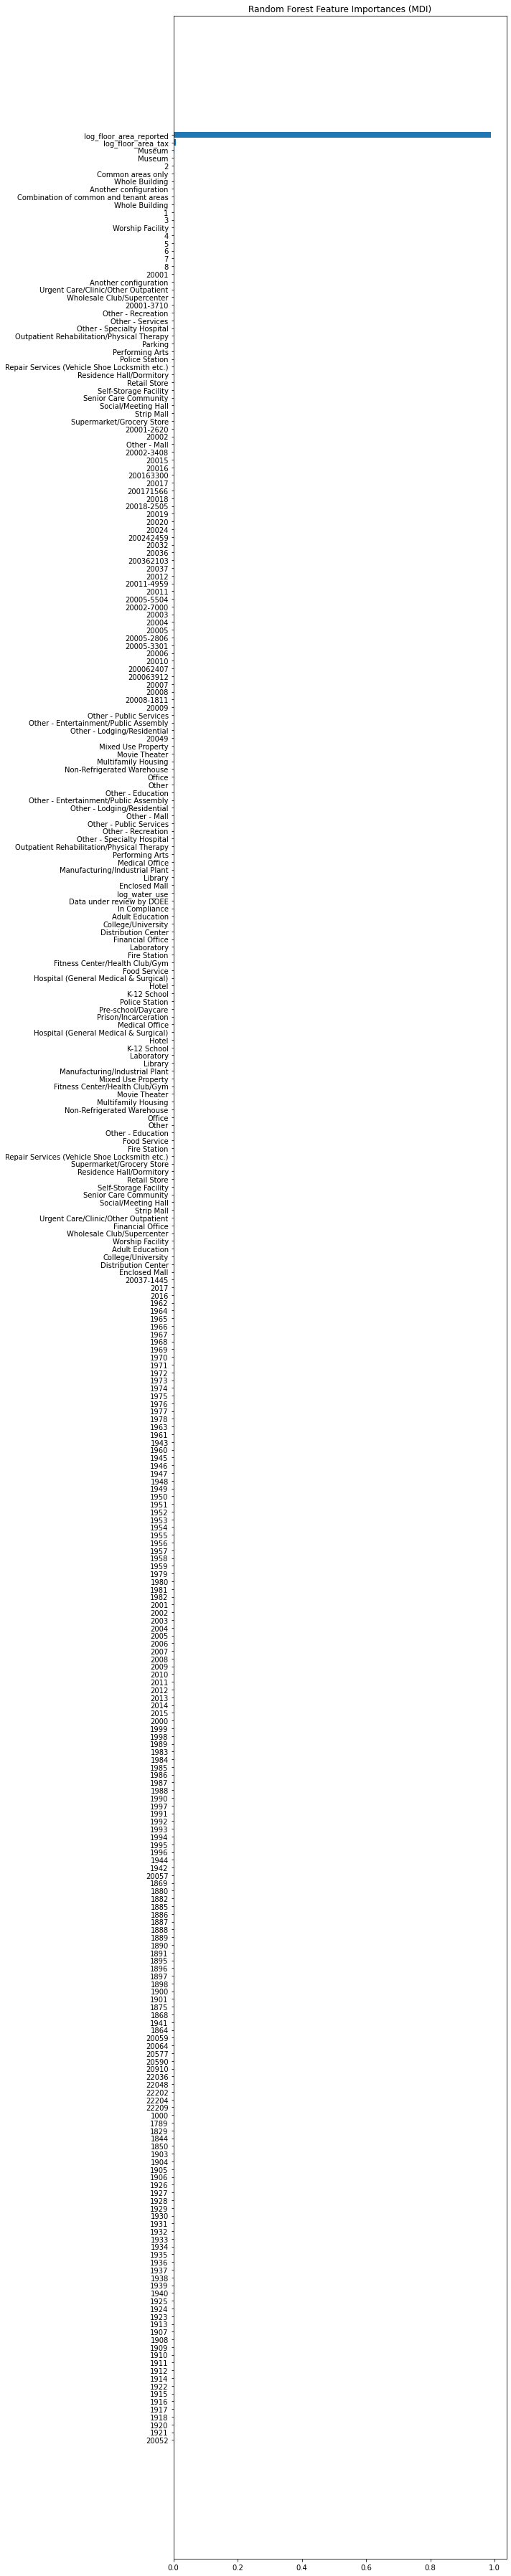

In [188]:
import pylab as plt
tree_feature_importances_dc = (
    rf_dc.feature_importances_)
sorted_idx_dc = tree_feature_importances_dc.argsort()

y_ticks_dc = np.arange(0, len(feature_names_dc))
fig, ax = plt.subplots(figsize=(10,50))
ax.barh(y_ticks_dc, tree_feature_importances_dc[sorted_idx_dc])
ax.set_yticklabels(feature_names_dc[sorted_idx_dc])
ax.set_yticks(y_ticks_dc)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

According to the random feature plot, the first two important columns are log floor area reported and log floor area tax. It indicates that the buildig energy consumptio is highly related to the builing area. My results is similiar to the paper.

In [210]:
rf_ld = RandomForestRegressor(max_depth=2, random_state=0)
rf_ld.fit(X_train_ld, y_train_ld)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [211]:
rf_ld.score(X_test_ld, y_test_ld)

0.6895891666306935

The accuracy of this model is 0.70, which meas 70% of the predicting data is same to the real data. 

In [212]:
rf_ld.feature_importances_

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [192]:
feature_names_ld = np.hstack([x1_ld.columns, encode_feature_ld])
feature_names_ld

array(['log_area', 'typical_fuel_eui_KWHM2',
       'typical_electricity_eui_KWHM2', 'x0_Anthracite', 'x0_Biogas',
       'x0_Biomass', 'x0_Coal', 'x0_District Heating',
       'x0_Grid Supplied Electricity', 'x0_LPG', 'x0_Natural Gas',
       'x0_None', 'x0_Oil', 'x0_Other', 'x1_Air Conditioning',
       'x1_Heating and Mechanical Ventilation',
       'x1_Heating and Natural Ventilation',
       'x1_Mechanical Ventilation Only',
       'x1_Mixed-mode with Mechanical Ventilation',
       'x1_Mixed-mode with Natural Ventilation',
       'x1_Natural Ventilation Only'], dtype=object)

In [215]:
feature_names_ld = np.concatenate([ld_features.drop(['heating_fuel_type', 'hvac_type', 'floor_area_SF'], axis=1).columns.values, np.concatenate(enc_ld.categories_)])

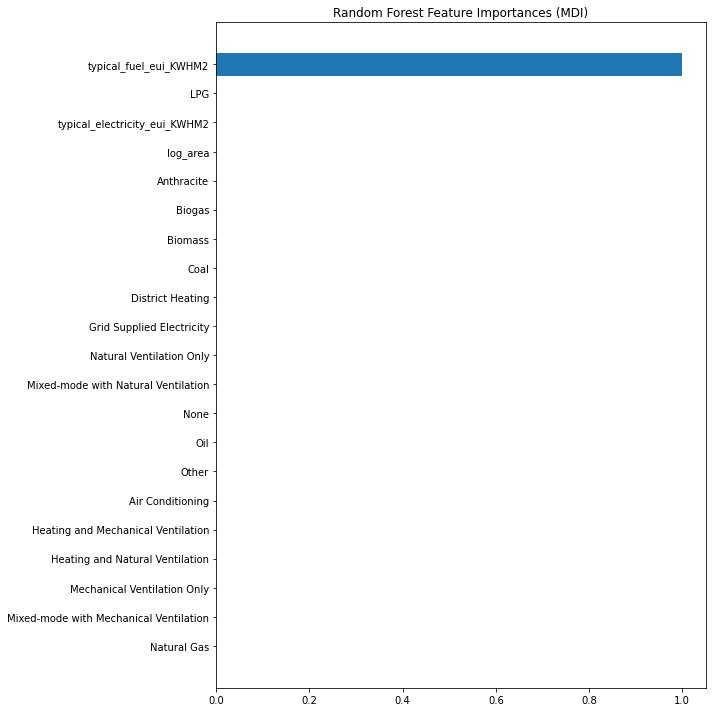

In [217]:
tree_feature_importances_ld = (
    rf_ld.feature_importances_)
sorted_idx_ld = tree_feature_importances_ld.argsort()

y_ticks_ld = np.arange(0, len(feature_names_ld))
fig, ax = plt.subplots(figsize=(10,10))
ax.barh(y_ticks_ld, tree_feature_importances_ld[sorted_idx_ld])
ax.set_yticklabels(feature_names_ld[sorted_idx_ld])
ax.set_yticks(y_ticks_ld)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

According to the random feature plot, the first important columns is typical_fuel_eui_KWHM2, which is differet to the paper result. I think it might be party due to the training and test split. The feature importance results in london is also different to it is in DC, which it might party explained by the local contexts of each city 

# useful links and methods and functions I used: 

```df.dropna()``` to remove observation with missing variables

```df.drop(columns, axis=1)``` to remove features (columns)


```np.log10()``` and ```np.isinf()``` to convert to log space and find infinite values  


one hot encoder https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html and https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/


KNN imputer https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html , https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/, and 
https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/  